# Week 7 - Image Processing With a CNN
<i>MSDS422</i>

---

This assignment follows the same structure as Assignment 6. We will employ at least a 2x2 completely crossed experimental design. We will again use a simple training-and-test regimen. The factors in the design may include numbers of layers and/or nodes within layers, types of layers (convolutional or pooling), and/or other hyperparameters. You will utilize convolutional neural networks (CNNs) within Python TensorFlow. 

This week, you will compete in the Dogs vs. Cats kernels Edition Kaggle.com competition, https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition (Links to an external site.). .  (Links to an external site.)Specifically, you will build models using the training set to forecast the test set. The images are in .jpg format, so you will need to research how to handle that.  You are required to submit no fewer than four models for evaluation by Kaggle.com, and you must provide your Kaggle.com scores and user ID for validation. 

## Management Problem

Assume that we are providing advice to a website provider who is looking for tools to automatically label images provided by end users. As we look across the factors in the study, making recommendations to management about image classification, we are most concerned about achieving the highest possible accuracy in image classification. That is, we should be willing to sacrifice training time for model accuracy. What type of machine learning model works best? If it is a convolutional neural network, what type of network should we use? Part of this recommendation may concern information about the initial images themselves (input data for the classification task). What types of images work best?

# Results:

I imported in only 2,000 images; 1,000 cat and 1,000 dogs. I scaled them to 128x128 and kept the color instead of using grayscale.
For this test I chose to experiement with the effects of changing the optmizer and the number of nodes in the two hidden layers. 

Based on the accuracy on the train/test split it appeared that Model 2 performed the best however what we see based on the Kaggle test submission (which uses logloss instead of accuracy) was that model 4 performed the best. This was surprising because based on my testing it appeared that the model had no predictive power.

|Model # | Optimizer | Nodes per Hidde Layer | Training Accuracy | Test Accuracy| Kaggle Score (Logloss) |
| --- | --- | --- | --- | --- | --- |
| 1 | Adam |32x64 | 89.69% | 63.00% | 2.84650 |
| 2 | rmsprop | 32x64 | 68.56% | 67.50% | 1.41296 |
| 3 | Adam | 64x128 | 89.56% | 60.75% | 2.02690 |
| 4 | rmsprop | 64x128 | 50.25% | 49.00% | 0.69316 |


**Management Answer:** 

At this point more work would need to be performed to get an accuracy that would be acceptable to put in use. Based on my small test it appeared that more nodes in the hidden layers would improve accuracy. Other things to test would be increaseing the resolution of the images, including more hidden layers, and changing other parameters like dropout and pooling. For this application we'd also want to include more categories since it sounds like the website users will not only be uploading images of cats and dogs.

---


# Appendix and Code

In [0]:
# Loading necessary libraries
from __future__ import division, print_function, absolute_import
from skimage import color, io
import numpy as np
import pandas as pd
import os
import os.path
from glob import glob
from matplotlib import pyplot as plt 

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from random import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from sklearn.model_selection import train_test_split

import cv2  
import re
import time
import logging
logging.getLogger('tensorflow').disabled = True


# Ensuring the models are repeatable
RANDOM_STATE = 1776
def reset_graph(seed= RANDOM_STATE):
    tf.compat.v1.reset_default_graph()
    tf.random.set_seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)

## Importing Data

In [0]:
# installing the kaggle package
!pip install -U -q kaggle

# Making a new directory for kaggle
!mkdir -p ~/.kaggle

# Uploading my kaggle.json api key
from google.colab import files
files.upload()

# copying my api key to my new kaggle folder
!cp kaggle.json ~/.kaggle/

# Hiding my API key
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [0]:
# Grabbing dataset from kaggle
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

# I'm uploading the training set manually, not using this
#!unzip '/content/train.zip'

# Unzipping the test data
!unzip '/content/test.zip'

## Prepping Training Data

In [0]:
# Manually uploaded the data from the Jump Start file, unzipping it
!unzip '/content/cats_dogs_images.zip'

In [0]:
# The paths to the directories where the original raster files are located
cat_image_dir_name = '/content/cats_dogs_images/cats'
dog_image_dir_name = '/content/cats_dogs_images/dogs'

In [0]:
#Saving formulas for use later

def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)
    
# Generate nicely sorted list of file names, excluding hidden files    
def directory_list (dir_name):
    start_list = os.listdir(dir_name)
    end_list = []
    for file in start_list:
        if (not file.startswith('.')):
            end_list.append(file) 
    end_list.sort(key = alphanum_key)        
    return(end_list)        

cat_file_names = directory_list(cat_image_dir_name)
dog_file_names = directory_list(dog_image_dir_name)    
    
# Convert image to numpy array... three channels for color
def parse_color(image_file_path):
    image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
    # Default cv2 is BGR... need RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return(image)

def parse_color_and_resize(image_file_path, size = (64, 64)):
    image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
    # Default cv2 is BGR... need RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)
    return(image)  

def show_color_image(image):
    plt.imshow(image) 
    plt.axis('off')
    plt.show()   

In [0]:
print('\nProcessing image files to 128x128 color')

# Create cats_1000_128_128_3 and numpy array for 1000 cat images in color
cats_1000_128_128_3 = np.zeros((1000, 128, 128, 3))  
for ifile in range(len(cat_file_names)):
    image_file_path = os.path.join(cat_image_dir_name, cat_file_names[ifile])
    image = parse_color_and_resize(image_file_path, size = (128, 128))
    cats_1000_128_128_3[ifile,:,:,:] = image
       
# Create dogs_1000_128_128_3 and numpy array for 1000 dog images in color   
dogs_1000_128_128_3 = np.zeros((1000, 128, 128, 3))  
for ifile in range(len(dog_file_names)):
    image_file_path = os.path.join(dog_image_dir_name, dog_file_names[ifile])
    image = parse_color_and_resize(image_file_path, size = (128, 128))
    dogs_1000_128_128_3[ifile,:,:,:] = image


# The directory where we store the numpy array objects
# store our smaller dataset
outdir = '/content/cats_dogs_images/arrays'
os.mkdir(outdir)    

np.save(os.path.join(outdir, 'cats_array.npy'), cats_1000_128_128_3)
np.save(os.path.join(outdir, 'dogs_array.npy'), dogs_1000_128_128_3)
    
print('\nRun complete')    

    


Processing image files to 128x128 color


In [5]:
# Merging cats and dogs together then creating the target variables

X_combined = np.concatenate((cats_1000_128_128_3, dogs_1000_128_128_3), axis = 0) 

# Target variables, 0 for cats and 1 for dogs
y_combined = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)

X_combined.shape

(2000, 128, 128, 3)

In [0]:
# Creating training and validation set split  
X_train, X_val, y_train, y_val = train_test_split(X_combined, y_combined, test_size=0.2, random_state=RANDOM_STATE)

# One hot encoding target
y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)

## Prepping Kaggle TEST data

In [0]:
# Prepping TEST data
test_image_dir_name = '/content/test'
test_file_names = directory_list(test_image_dir_name) 

# Creating np array for kaggle test data  
test_data = np.zeros((12500, 128, 128, 3))  
for ifile in range(len(test_file_names)):
    image_file_path = os.path.join(test_image_dir_name, test_file_names[ifile])
    image = parse_color_and_resize(image_file_path, size = (128, 128))
    test_data[ifile,:,:,:] = image

np.save(os.path.join(outdir, 'test_array.npy'), test_data)

## EDA

In [8]:
# Array representation of an image (only showing first 10 pixels)
X_train[0][0][0:10]

array([[250., 251., 241.],
       [232., 219., 210.],
       [232., 216., 201.],
       [232., 221., 198.],
       [234., 223., 203.],
       [236., 218., 204.],
       [238., 226., 211.],
       [239., 226., 211.],
       [240., 227., 212.],
       [240., 228., 213.]])

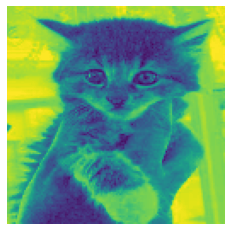

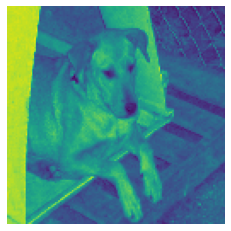

In [0]:
show_color_image(cats_1000_128_128_3[100,:,:,2])
show_color_image(dogs_1000_128_128_3[100,:,:,0])

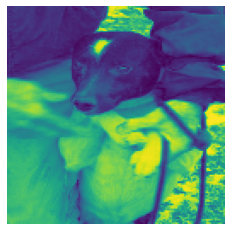

In [0]:
show_color_image(test_data[0,:,:,0])

## Modeling

In [0]:
# Model 1 - Adam optimizer - Hidden layers 32x64
reset_graph()

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3), input_shape=(128, 128, 3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(32, (3,3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3,3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Activation('softmax'))

# Compiling
model.compile(loss='categorical_crossentropy',
              optimizer= 'adam',  #'rmsprop',
              metrics=['accuracy'], )
              
# Fitting
history = model.fit(X_train, y_train, epochs=15, 
                    validation_data=(X_val, y_val) )

Epoch 1/15
50/50 [==============================] - 2s 32ms/step - loss: 10.9384 - accuracy: 0.4981 - val_loss: 0.6906 - val_accuracy: 0.5100
Epoch 2/15
50/50 [==============================] - 1s 25ms/step - loss: 0.6860 - accuracy: 0.5519 - val_loss: 0.6871 - val_accuracy: 0.5825
Epoch 3/15
50/50 [==============================] - 1s 25ms/step - loss: 0.6796 - accuracy: 0.5719 - val_loss: 0.6843 - val_accuracy: 0.5850
Epoch 4/15
50/50 [==============================] - 1s 25ms/step - loss: 0.6572 - accuracy: 0.6231 - val_loss: 0.6848 - val_accuracy: 0.6200
Epoch 5/15
50/50 [==============================] - 1s 25ms/step - loss: 0.6102 - accuracy: 0.6494 - val_loss: 0.7074 - val_accuracy: 0.5650
Epoch 6/15
50/50 [==============================] - 1s 25ms/step - loss: 0.5732 - accuracy: 0.7050 - val_loss: 0.7219 - val_accuracy: 0.5775
Epoch 7/15
50/50 [==============================] - 1s 25ms/step - loss: 0.5452 - accuracy: 0.7450 - val_loss: 0.7785 - val_accuracy: 0.5725
Epoch 8/15
5

In [0]:
# Model 2 - rmsprop optimizer - Hidden layers 32x64
reset_graph()

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3), input_shape=(128, 128, 3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(32, (3,3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3,3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Activation('softmax'))

# Compiling
model.compile(loss='categorical_crossentropy',
              optimizer= 'rmsprop',
              metrics=['accuracy'], )
              
# Fitting
history = model.fit(X_train, y_train, epochs=15, 
                    validation_data=(X_val, y_val) )

Epoch 1/15
50/50 [==============================] - 1s 30ms/step - loss: 27.8412 - accuracy: 0.5163 - val_loss: 0.6816 - val_accuracy: 0.5850
Epoch 2/15
50/50 [==============================] - 1s 25ms/step - loss: 1.0809 - accuracy: 0.5656 - val_loss: 0.6922 - val_accuracy: 0.5300
Epoch 3/15
50/50 [==============================] - 1s 25ms/step - loss: 0.9373 - accuracy: 0.5213 - val_loss: 0.6947 - val_accuracy: 0.4925
Epoch 4/15
50/50 [==============================] - 1s 25ms/step - loss: 0.7850 - accuracy: 0.5169 - val_loss: 0.7011 - val_accuracy: 0.4900
Epoch 5/15
50/50 [==============================] - 1s 25ms/step - loss: 0.6994 - accuracy: 0.5219 - val_loss: 0.6901 - val_accuracy: 0.5525
Epoch 6/15
50/50 [==============================] - 1s 25ms/step - loss: 0.7083 - accuracy: 0.5138 - val_loss: 0.6910 - val_accuracy: 0.5475
Epoch 7/15
50/50 [==============================] - 1s 24ms/step - loss: 0.7410 - accuracy: 0.5219 - val_loss: 0.6906 - val_accuracy: 0.5350
Epoch 8/15
5

In [0]:
# Model 3 - Adam optimizer - Hidden layers 64x128
reset_graph()

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3), input_shape=(128, 128, 3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3,3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(128, (3,3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Activation('softmax'))

# Compiling
model.compile(loss='categorical_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'], )
              
# Fitting
history = model.fit(X_train, y_train, epochs=15, 
                    validation_data=(X_val, y_val) )

Epoch 1/15
50/50 [==============================] - 2s 36ms/step - loss: 8.8091 - accuracy: 0.5219 - val_loss: 0.6969 - val_accuracy: 0.4875
Epoch 2/15
50/50 [==============================] - 2s 31ms/step - loss: 0.6820 - accuracy: 0.5500 - val_loss: 0.6977 - val_accuracy: 0.5500
Epoch 3/15
50/50 [==============================] - 2s 31ms/step - loss: 0.6508 - accuracy: 0.6156 - val_loss: 0.7024 - val_accuracy: 0.5250
Epoch 4/15
50/50 [==============================] - 2s 30ms/step - loss: 0.5974 - accuracy: 0.6794 - val_loss: 0.7357 - val_accuracy: 0.5275
Epoch 5/15
50/50 [==============================] - 2s 30ms/step - loss: 0.5662 - accuracy: 0.7144 - val_loss: 0.7844 - val_accuracy: 0.5650
Epoch 6/15
50/50 [==============================] - 2s 31ms/step - loss: 0.5178 - accuracy: 0.7369 - val_loss: 0.7963 - val_accuracy: 0.4950
Epoch 7/15
50/50 [==============================] - 2s 30ms/step - loss: 0.4883 - accuracy: 0.7544 - val_loss: 0.9557 - val_accuracy: 0.5300
Epoch 8/15
50

In [0]:
# Model 4 - rmsprop optimizer - Hidden layers 64x128
reset_graph()

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3), input_shape=(128, 128, 3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3,3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(128, (3,3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Activation('softmax'))

# Compiling
model.compile(loss='categorical_crossentropy',
              optimizer= 'rmsprop',
              metrics=['accuracy'], )
              
# Fitting
history = model.fit(X_train, y_train, epochs=15, 
                    validation_data=(X_val, y_val) )

Epoch 1/15
50/50 [==============================] - 2s 35ms/step - loss: 22.4095 - accuracy: 0.5381 - val_loss: 0.8558 - val_accuracy: 0.5300
Epoch 2/15
50/50 [==============================] - 2s 31ms/step - loss: 1.2371 - accuracy: 0.5100 - val_loss: 0.6932 - val_accuracy: 0.4900
Epoch 3/15
50/50 [==============================] - 2s 30ms/step - loss: 0.7005 - accuracy: 0.4963 - val_loss: 0.6932 - val_accuracy: 0.4900
Epoch 4/15
50/50 [==============================] - 2s 31ms/step - loss: 0.6932 - accuracy: 0.4800 - val_loss: 0.6932 - val_accuracy: 0.4900
Epoch 5/15
50/50 [==============================] - 2s 31ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6932 - val_accuracy: 0.4900
Epoch 6/15
50/50 [==============================] - 2s 31ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4900
Epoch 7/15
50/50 [==============================] - 2s 31ms/step - loss: 0.6932 - accuracy: 0.4888 - val_loss: 0.6932 - val_accuracy: 0.4900
Epoch 8/15
5

## Kaggle Submission

In [0]:
# Transforming and predicting on Kaggle's test set
final_predictions = model.predict_proba(test_data)

In [0]:
reset_graph()

# Packaging submission up
counter = range(1, len(test_data) + 1)
solution = pd.DataFrame({"id": counter, "label":list(final_predictions)})
cols = ['label']

for col in cols:
    solution[col] = solution[col].map(lambda x: str(x[0]).lstrip('[').rstrip(']')).astype(float)

solution.to_csv("Submission4.csv", index = False)

In [10]:
# Submitting to kaggle
!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f Submission4.csv -m "Week7: Submission 4"

100% 172k/172k [00:03<00:00, 55.6kB/s]
Successfully submitted to Dogs vs. Cats Redux: Kernels Edition